### 🧩 Imports

Import all the necessary libraries:
- `json` for reading/writing JSON files.
- `pandas` and `numpy` for data manipulation.
- `random` for generating random synthetic data.
- `IsolationForest` from `sklearn` for anomaly detection.
- `joblib` for saving the trained model.

In [11]:
import json
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np
import random
import joblib

### 📊 Generate Dataset

Create synthetic "normal" network traffic data to train an anomaly detection model. Each sample includes:

- `src_port`: randomly selected from common service ports.
- `dst_port`: a random high port number.
- `packet_size`: typical packet sizes.
- `duration_ms`: duration of the communication.
- `protocol`: randomly selected between TCP and UDP.

This data is saved to `training_data.json` for future use.

In [13]:
import os

# Create dataset directory if it doesn't exist
os.makedirs("dataset", exist_ok=True)

# Generate synthetic dataset
COMMON_PORTS = [80, 443, 22, 8080]

def generate_normal_data():
    return {
        "src_port": random.choice(COMMON_PORTS),
        "dst_port": random.randint(1024, 65535),
        "packet_size": random.randint(100, 1500),
        "duration_ms": random.randint(50, 500),
        "protocol": random.choice(["TCP", "UDP"])
    }

dataset = [generate_normal_data() for _ in range(1000)]

# Save to dataset/training_data.json
with open("dataset/training_data.json", "w") as f:
    json.dump(dataset, f, indent=2)

print("✅ training_data.json has been saved successfully.")


✅ training_data.json has been saved successfully.


In [14]:
with open("./dataset/training_data.json") as f:
    raw_data = json.load(f)

df = pd.DataFrame(raw_data)
display(df)

,src_port,dst_port,packet_size,duration_ms,protocol
0,22,15758,733,155,TCP
1,443,19263,1346,448,TCP
2,443,24387,1121,285,TCP
3,443,49610,514,236,TCP
4,8080,42075,302,218,TCP
...,...,...,...,...,...
995,8080,8971,489,161,UDP
996,80,59442,1467,329,UDP
997,22,18364,1313,75,TCP
998,22,4155,388,492,UDP


### 🧼 Preprocessing Function

Machine learning models like Isolation Forest require **numerical input only**. Any categorical variables, such as the `protocol` column (`TCP`, `UDP`), must be converted into numbers.

We handle this with **one-hot encoding**, using `pd.get_dummies`.

#### 🛠️ Preprocessing Steps:

1. **Identify categorical columns**:
   - In our case, the `protocol` column is categorical (`TCP`, `UDP`).

2. **Use `pd.get_dummies`**:
   - This creates a new binary column for each category.
   - For instance:
     ```
     protocol
     ---------
     TCP   →   protocol_UDP = 0
     UDP   →   protocol_UDP = 1
     ```
   - Setting `drop_first=True` prevents multicollinearity by dropping the first category (`TCP` here), as it can be inferred from the others.

3. **Return a DataFrame with all numerical values**:
   - This is ready for model input.

> ✅ This preprocessing is essential to avoid errors during training and ensure the model can learn from categorical variables.

In [15]:
# def preprocess_data(df):
#     #TODO 1: Implement preprocessing steps
#     return np.array(df)


def preprocess_data(df):
    df = pd.get_dummies(df, columns=["protocol"], drop_first=True)
    return df


### 🤖 Train Isolation Forest

The `IsolationForest` algorithm is an unsupervised model used to detect anomalies. It isolates observations by randomly selecting features and splitting values.

- `n_estimators=100`: number of trees in the forest.
- `contamination=0.01`: assumes 1% of the data is anomalous.
- `random_state=42`: ensures reproducibility.

The model is trained on the preprocessed numerical dataset.

In [16]:
# model = IsolationForest(contamination=0.1, random_state=42)
# model.fit()

model = IsolationForest(contamination=0.1, random_state=42)
processed_df = preprocess_data(df)
model.fit(processed_df)


IsolationForest(contamination=0.1, random_state=42)

### 💾 Save Trained Model

Save the trained model using `joblib`, which allows for efficient serialization and deserialization. This saved model can be reused later for inference or deployment.


In [17]:
joblib.dump(model, "anomaly_model.joblib")

['anomaly_model.joblib']

# predict data

In [26]:
# model.predict()


predictions = model.predict(processed_df)
print(predictions[:100])


[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1]


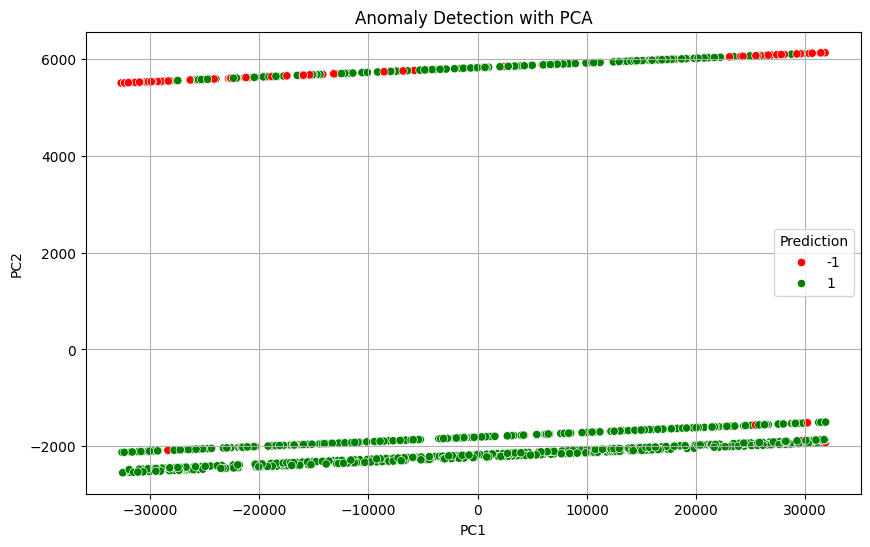

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
reduced = pca.fit_transform(processed_df)

viz_df = pd.DataFrame(reduced, columns=["PC1", "PC2"])
viz_df["Prediction"] = predictions

palette = {1: "green", -1: "red"}

plt.figure(figsize=(10, 6))
sns.scatterplot(data=viz_df, x="PC1", y="PC2", hue="Prediction", palette=palette)
plt.title("Anomaly Detection with PCA")
plt.grid(True)
plt.show()


In [21]:
df["Prediction"] = predictions
anomalies = df[df["Prediction"] == -1]
anomalies.to_csv("anomalies.csv", index=False)


In [22]:
scores = model.decision_function(processed_df)
df["Score"] = scores
df["Prediction"] = predictions


In [23]:
anomalies = df[df["Prediction"] == -1]
anomalies.to_csv("anomalies_with_score.csv", index=False)


In [25]:
df["Prediction"] = predictions
anomalies = df[df["Prediction"] == -1]
anomalies.to_csv("anomalies.csv", index=False)

print(f"{len(anomalies)} anomalies saved to 'anomalies.csv'")


100 anomalies saved to 'anomalies.csv'


In [24]:
print("Top 5 anomalies with confidence score:")
print(anomalies.sort_values(by="Score").head())


Top 5 anomalies with confidence score:
     src_port  dst_port  packet_size  duration_ms protocol  Prediction  \
368      8080     63259          150          497      TCP          -1   
161      8080      3783         1332          105      TCP          -1   
87       8080     63017         1435          203      TCP          -1   
839      8080     61792          286          497      TCP          -1   
911      8080     61099          106          367      TCP          -1   

        Score  
368 -0.068875  
161 -0.051441  
87  -0.050589  
839 -0.048002  
911 -0.046934  
